<a href="https://colab.research.google.com/github/Altaieb-Mohammed/lab_2corse/blob/master/lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   debts               10000 non-null  float64
 1   bequests            10000 non-null  float64
 2   wife                10000 non-null  int64  
 3   husband             10000 non-null  int64  
 4   sons                10000 non-null  int64  
 5   daughters           10000 non-null  int64  
 6   father              10000 non-null  int64  
 7   mother              10000 non-null  int64  
 8   brothers            10000 non-null  int64  
 9   sisters             10000 non-null  int64  
 10  debts_minmax        10000 non-null  float64
 11  bequests_minmax     10000 non-null  float64
 12  wife_minmax         10000 non-null  float64
 13  husband_minmax      10000 non-null  float64
 14  sons_minmax         10000 non-null  float64
 15  daughters_minmax    10000 non-nul

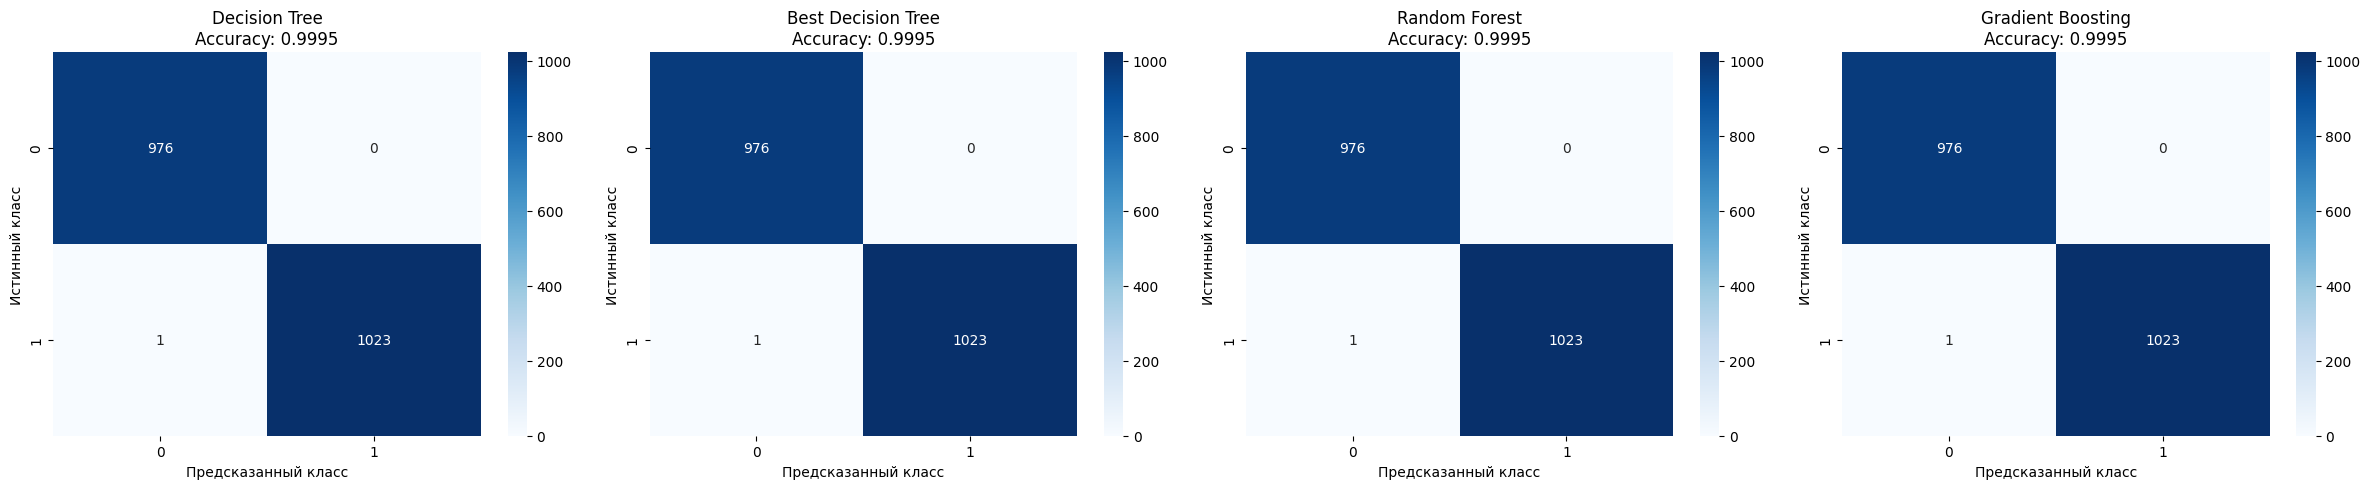

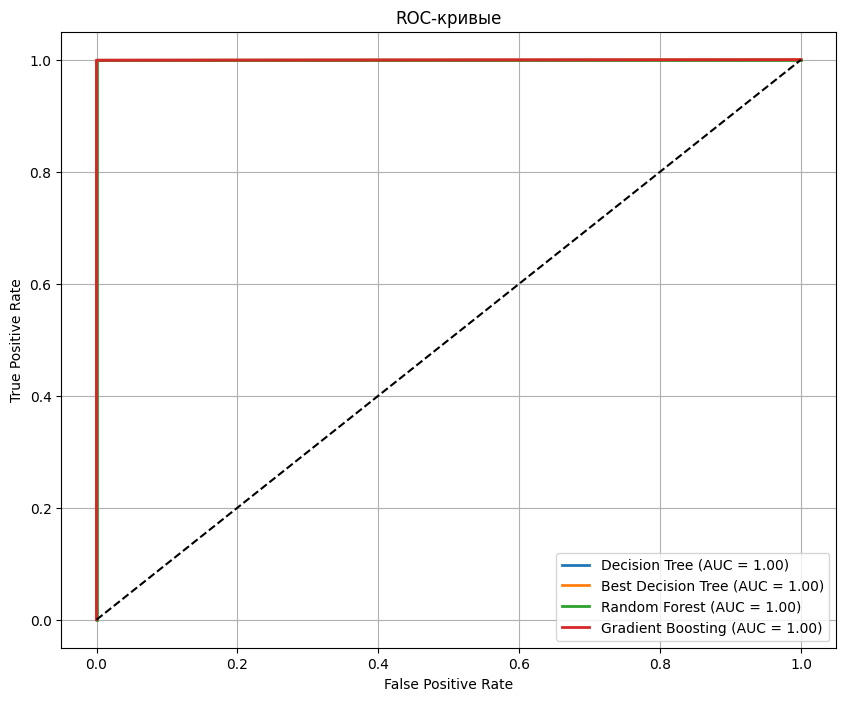

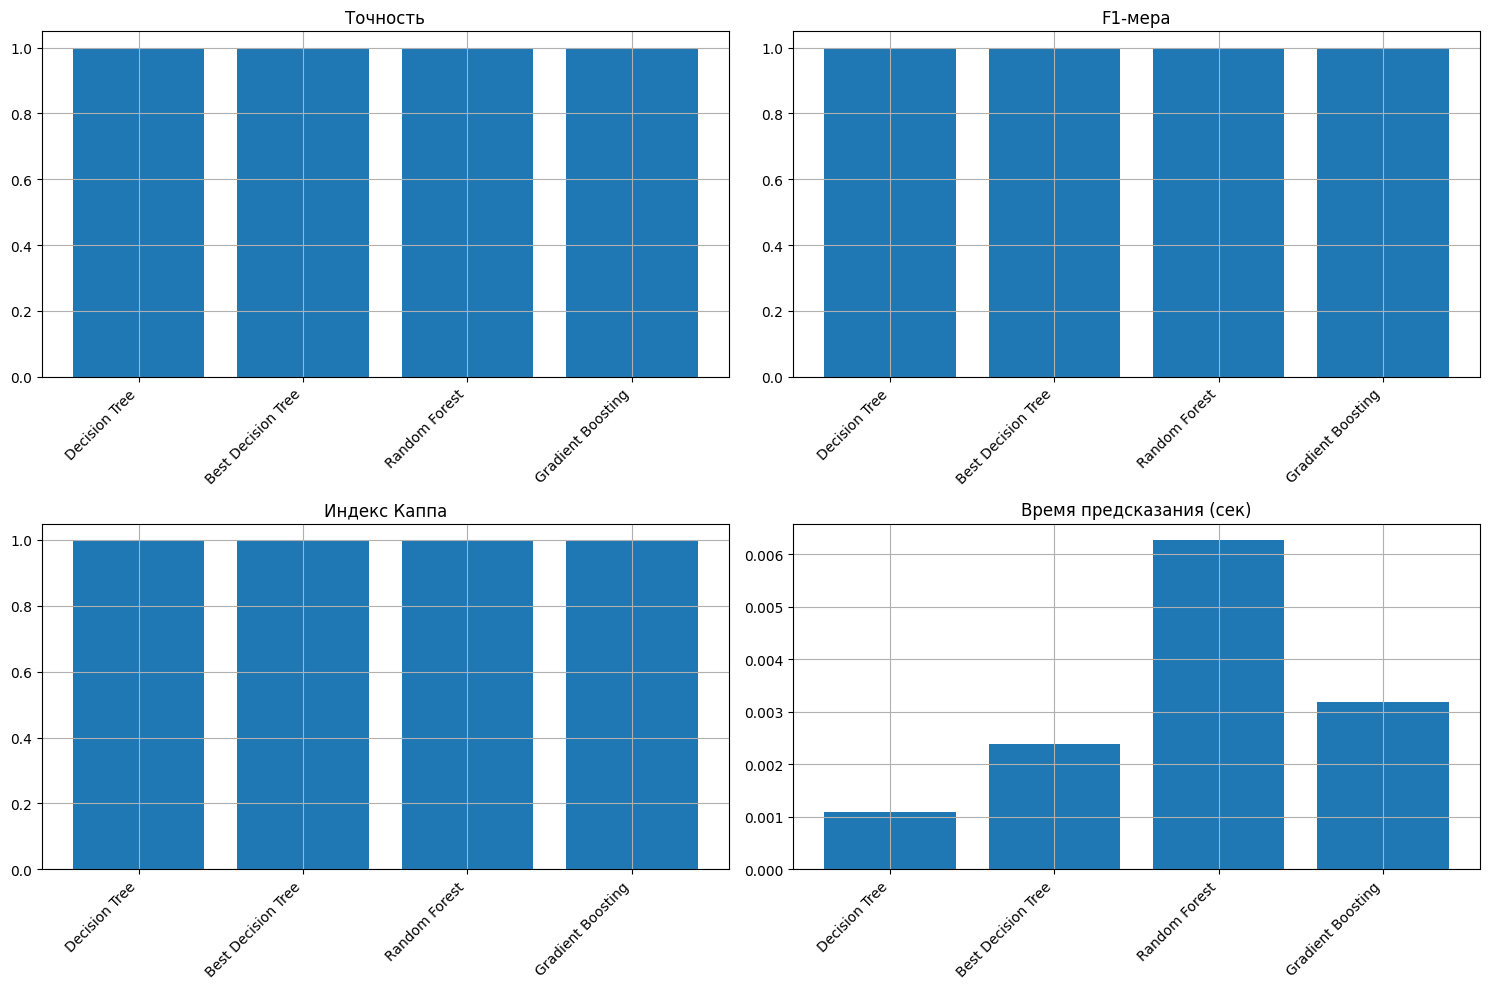

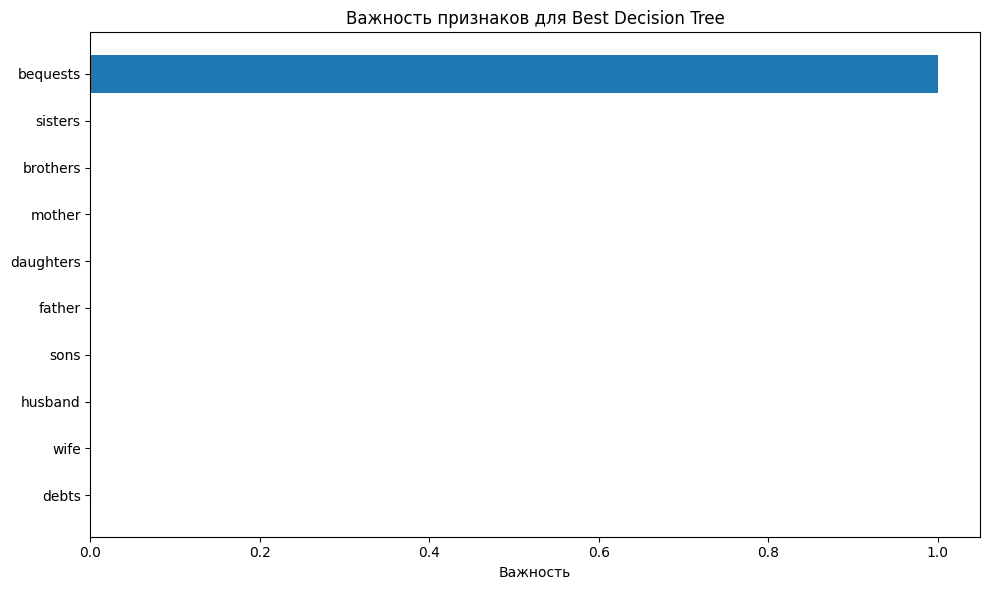

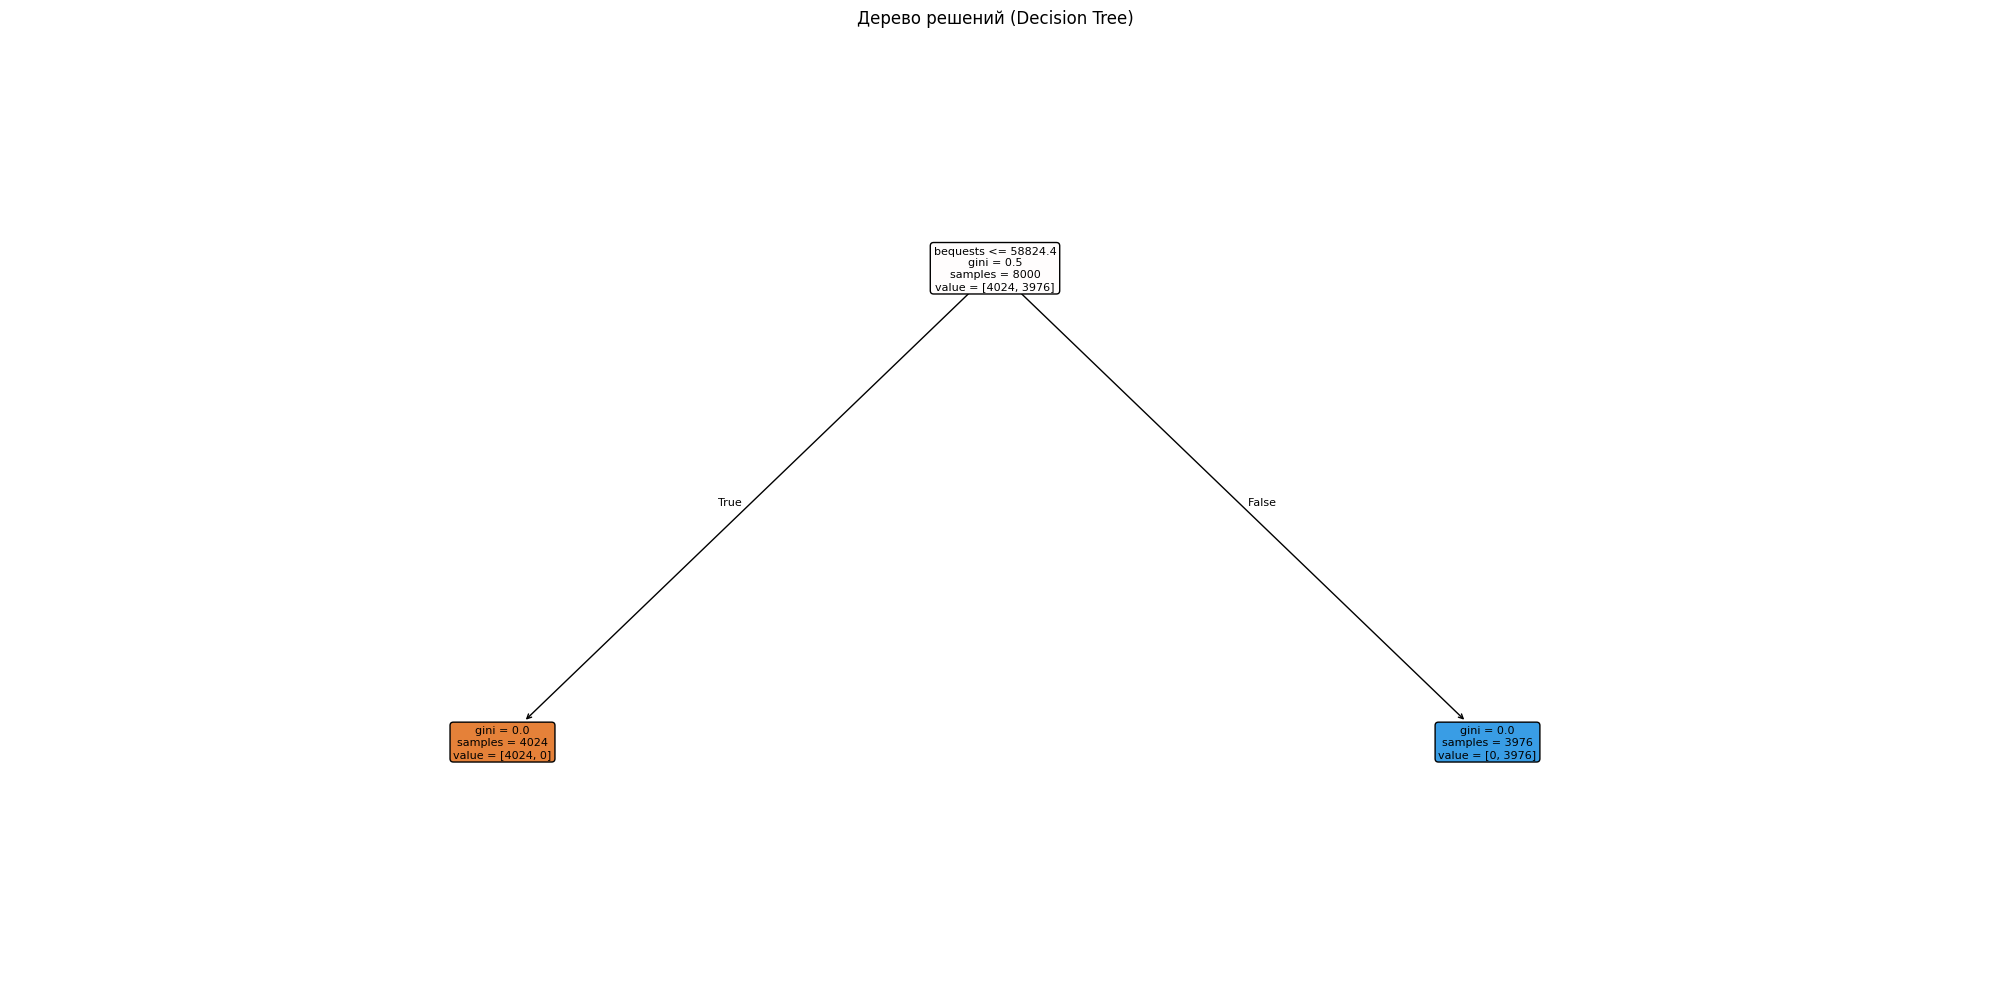

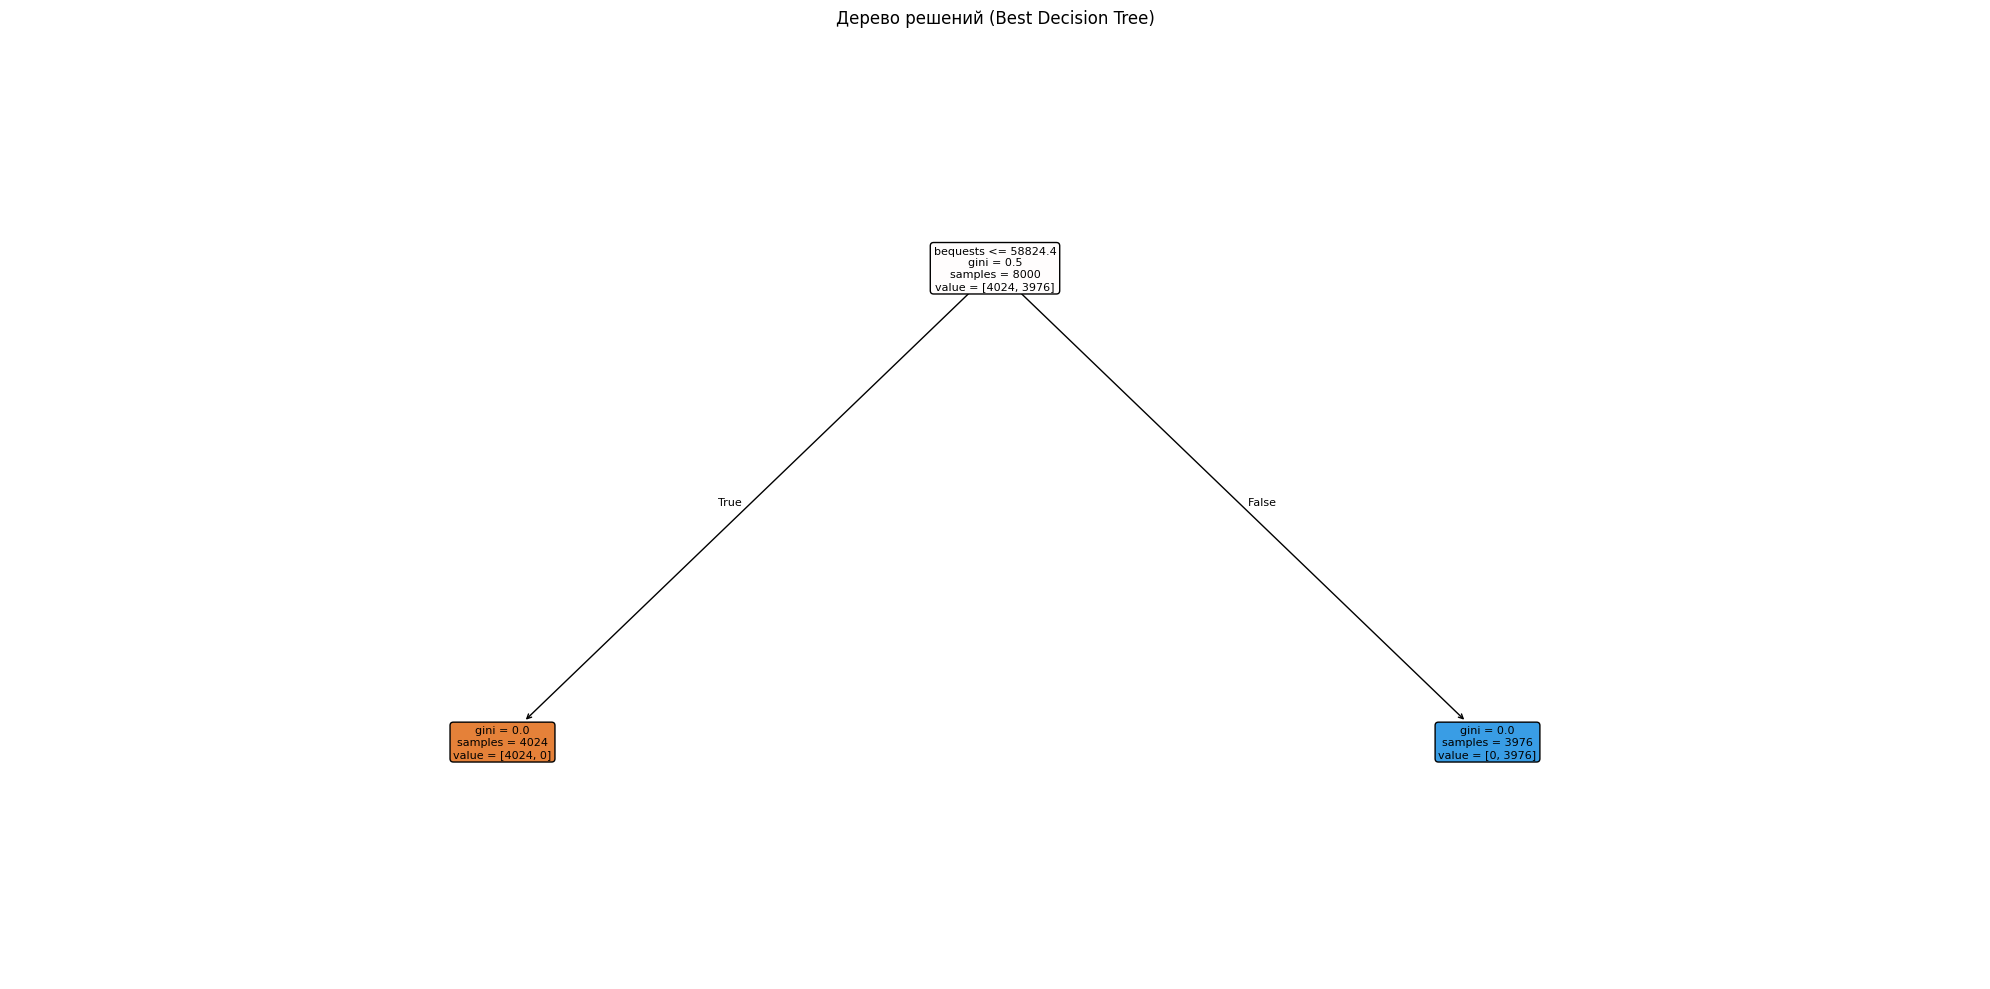


Сравнение моделей:
                    Метрика  Decision Tree  Best Decision Tree  Random Forest  \
0                  Accuracy       0.999500            0.999500       0.999500   
1                  F1-score       0.999500            0.999500       0.999500   
2                     Kappa       0.998999            0.998999       0.998999   
3  Время предсказания (сек)       0.001084            0.002380       0.006264   
4              Индекс Джини       0.499712            0.499712       0.499712   
5                  Энтропия       0.999584            0.999584       0.999584   

   Gradient Boosting  
0           0.999500  
1           0.999500  
2           0.998999  
3           0.003176  
4           0.499712  
5           0.999584  

Лучшая модель по точности: Decision Tree с accuracy 0.9995


In [1]:
# -------------------------------------------------------------- Лабораторная работа №7: обучение и анализ моделей на основе деревьев решений

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc, classification_report, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
import time
import warnings
warnings.filterwarnings('ignore')

# --- Data Loading and Preparation ---
def load_data(url):
    data = pd.read_csv(url)
    print("Информация о данных:")
    print(data.info())
    print("\nПервые 5 строк:")
    print(data.head())
    # Создаем бинарный таргет, если его нет
    if 'high_bequest' not in data.columns:
        median_bequest = data['bequests'].median()
        data['high_bequest'] = (data['bequests'] >= median_bequest).astype(int)
    feature_cols = ['debts', 'bequests', 'wife', 'husband', 'sons', 'daughters', 'father', 'mother', 'brothers', 'sisters']
    X = data[feature_cols].values
    y = data['high_bequest'].values
    return X, y, feature_cols

# --- Impurity Metrics ---
def calculate_impurity_metrics(y_true):
    y_true = np.array(y_true)
    classes, counts = np.unique(y_true, return_counts=True)
    probabilities = counts / len(y_true)
    gini = 1 - np.sum(probabilities ** 2)
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
    return gini, entropy

# --- Model Evaluation ---
def evaluate_model(model, X_test, y_test, model_name, feature_names=None):
    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time

    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)

    n_classes = len(np.unique(y_test))
    if n_classes == 2:
        try:
            y_score = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc_val = auc(fpr, tpr)
        except:
            fpr, tpr, roc_auc_val = None, None, None
    else:
        fpr, tpr, roc_auc_val = None, None, None

    gini, entropy = calculate_impurity_metrics(y_test)

    feature_importance = None
    if hasattr(model, 'feature_importances_') and feature_names is not None:
        feature_importance = dict(zip(feature_names, model.feature_importances_))

    return {
        'name': model_name,
        'accuracy': accuracy,
        'confusion_matrix': confusion,
        'f1_score': f1,
        'kappa': kappa,
        'prediction_time': prediction_time,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc_val,
        'gini': gini,
        'entropy': entropy,
        'feature_importance': feature_importance,
        'model': model
    }

# --- Visualization ---
def visualize_results(results, X_test, y_test, feature_names=None):
    cmap = plt.cm.Blues
    n_models = len(results)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    if n_models == 1:
        axes = [axes]
    for i, res in enumerate(results):
        sns.heatmap(res['confusion_matrix'], annot=True, fmt='d', cmap=cmap, ax=axes[i])
        axes[i].set_title(f"{res['name']}\nAccuracy: {res['accuracy']:.4f}")
        axes[i].set_ylabel('Истинный класс')
        axes[i].set_xlabel('Предсказанный класс')
    plt.tight_layout()
    plt.show()

    # ROC-кривые для бинарной классификации
    if all(res['roc_auc'] is not None for res in results):
        plt.figure(figsize=(10, 8))
        for res in results:
            plt.plot(res['fpr'], res['tpr'], lw=2, label=f"{res['name']} (AUC = {res['roc_auc']:.2f})")
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-кривые')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Сравнение метрик по моделям
    metrics = ['accuracy', 'f1_score', 'kappa', 'prediction_time']
    metric_names = ['Точность', 'F1-мера', 'Индекс Каппа', 'Время предсказания (сек)']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    model_names = [r['name'] for r in results]
    for i, (metric, name) in enumerate(zip(metrics, metric_names)):
        values = [r[metric] for r in results]
        axes[i].bar(model_names, values)
        axes[i].set_title(name)
        axes[i].set_xticklabels(model_names, rotation=45, ha='right')
        axes[i].grid(True)
    plt.tight_layout()
    plt.show()

    # Важность признаков
    for res in results:
        if res['feature_importance'] is not None:
            plt.figure(figsize=(10, 6))
            fi = res['feature_importance']
            features = list(fi.keys())
            importances = list(fi.values())
            indices = np.argsort(importances)
            plt.barh(np.array(features)[indices], np.array(importances)[indices])
            plt.title(f"Важность признаков для {res['name']}")
            plt.xlabel("Важность")
            plt.tight_layout()
            plt.show()

    # Визуализация дерева решений (только для Decision Tree)
    from sklearn import tree
    for res in results:
        if 'Decision Tree' in res['name']:
            plt.figure(figsize=(20, 10))
            model_to_plot = res['model']
            if hasattr(model_to_plot, 'best_estimator_'):
                model_to_plot = model_to_plot.best_estimator_
            tree.plot_tree(model_to_plot, feature_names=feature_names, filled=True, rounded=True, fontsize=8)
            plt.title(f"Дерево решений ({res['name']})")
            plt.tight_layout()
            plt.show()

# --- Main pipeline ---
def main():
    url = "https://raw.githubusercontent.com/Altaieb-Mohammed/lab_2corse/master/inheritance_combined.csv"
    X, y, feature_names = load_data(url)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Размер обучающей выборки: {X_train.shape}, тестовой: {X_test.shape}")
    print(f"Количество классов: {len(np.unique(y))}")

    gini, entropy = calculate_impurity_metrics(y)
    print(f"Индекс Джини для набора данных: {gini:.4f}")
    print(f"Энтропия Шеннона для набора данных: {entropy:.4f}")

    results = []

    # Decision Tree с подбором параметров
    print("\nОбучение Decision Tree...")
    param_grid_dt = {'max_depth': [None, 3, 5, 7, 10], 'max_features': [None, 'sqrt', 'log2', 0.5]}
    dt_model = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy')
    dt_model.fit(X_train, y_train)
    print(f"Лучшие параметры Decision Tree: {dt_model.best_params_}")

    best_dt = DecisionTreeClassifier(random_state=42, **dt_model.best_params_)
    best_dt.fit(X_train, y_train)

    results.append(evaluate_model(dt_model, X_test, y_test, "Decision Tree", feature_names))
    results.append(evaluate_model(best_dt, X_test, y_test, "Best Decision Tree", feature_names))

    # Random Forest с подбором параметров
    print("\nОбучение Random Forest...")
    param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'max_features': [None, 'sqrt', 'log2']}
    rf_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
    rf_model.fit(X_train, y_train)
    print(f"Лучшие параметры Random Forest: {rf_model.best_params_}")

    results.append(evaluate_model(rf_model, X_test, y_test, "Random Forest", feature_names))

    # Gradient Boosting с подбором параметров
    print("\nОбучение Gradient Boosting...")
    param_grid_gb = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7], 'max_features': [None, 'sqrt', 'log2']}
    gb_model = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=5, scoring='accuracy')
    gb_model.fit(X_train, y_train)
    print(f"Лучшие параметры Gradient Boosting: {gb_model.best_params_}")

    results.append(evaluate_model(gb_model, X_test, y_test, "Gradient Boosting", feature_names))

    print("\nВизуализация результатов...")
    visualize_results(results, X_test, y_test, feature_names)

    print("\nСравнение моделей:")
    comparison = pd.DataFrame({
        'Метрика': ['Accuracy', 'F1-score', 'Kappa', 'Время предсказания (сек)', 'Индекс Джини', 'Энтропия']
    })
    for r in results:
        comparison[r['name']] = [r['accuracy'], r['f1_score'], r['kappa'], r['prediction_time'], r['gini'], r['entropy']]
    print(comparison)

    best = max(results, key=lambda x: x['accuracy'])
    print(f"\nЛучшая модель по точности: {best['name']} с accuracy {best['accuracy']:.4f}")

if __name__ == "__main__":
    main()
